In [46]:
from linescanning import (
    prf,
    optimal,
    pycortex,
    plotting,
    fitting
)
import matplotlib.pyplot as plt
import os
import numpy as np
import cortex
opj = os.path.join
import seaborn as sns
import pandas as pd
import scipy.stats as stats

# for prf analysis
%matplotlib inline
from linescanning import prf, plotting, fitting
from prfpy import model, rf, timecourse
import numpy as np
import os
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
opd = os.path.dirname
opj = os.path.join
from prfpy.stimulus import PRFStimulus2D
import scipy.signal as signal
from nilearn.glm.first_level.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative
#!/usr/bin/env python
#$ -j Y
#$ -cwd
#$ -V
import ast
import getopt
import scipy
from linescanning import (
    prf,
    utils,
    dataset,
    plotting,
    preproc,
    optimal
)
import numpy as np
import nibabel as nb
import pandas as pd
import os
from scipy import io
import sys
import warnings
import json
import pickle
import mkl
mkl.set_num_threads=1
standard_max_threads = mkl.get_max_threads()
from datetime import datetime, timedelta
from linescanning.prf import *
import math
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from past.utils import old_div
from prfpy.stimulus import *
from prfpy.fit import *
from prfpy.model import *
from prfpy import timecourse
import random
from scipy.ndimage import rotate
from scipy import signal, io
import subprocess
import time
import yaml
import cortex
import scipy.stats as stats
from statsmodels.stats.weightstats import DescrStatsW, ttost_paired
from statsmodels.stats.descriptivestats import Description
from seaborn import regression
import statsmodels.api as sm
warnings.filterwarnings('ignore')
from seaborn import regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from linescanning import prf, optimal, pycortex
import numpy as np

In [47]:
%%capture
import numpy as np
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter 
from prfpy.model import DoG_Iso2DGaussianModel
from prfpy.fit import DoG_Iso2DGaussianFitter 
from prfpy.model import Norm_Iso2DGaussianModel
from prfpy.fit import Norm_Iso2DGaussianFitter 
from prfpy.model import CSS_Iso2DGaussianModel
from prfpy.fit import CSS_Iso2DGaussianFitter 
from linescanning import prf
import os
from prfpy import rf,stimulus
from prfpy.fit import *
from prfpy.model import *
opd = os.path.dirname
opj = os.path.join

#/packages/development/anaconda/3-8/envs/preproc/lib/python3.9/site-packages/jupyter_core/paths.py

qsub -o $DIR_DATA_HOME/derivatives/prf/sub-001/ses-2_train-test -N sub-001_ses-2_test_v3 -q verylong.q -pe smp 10 $DIR_DATA_HOME/code/def_code/function_cv.py --sub 001 --ses 2 --v3 --njobs 10 --verbose  --cv --tc


# Functions

#### Load design matrix

In [ ]:
def load_dm(cut_volumes = True):
    
    #### load design matrix ###
    screen_size_cm =39.3
    screen_distance_cm=210
    grid_nr = 20
    TR= 1.5
    
    if cut_volumes:
        n_volumes = 5
    else:
        n_volumes = 0

    design = prf.read_par_file(opj(opd(opd(prf.__file__)), '/data1/projects/Meman1/projects/pilot/code', 'design_task-2R.mat'))

    prf_stim = PRFStimulus2D(screen_size_cm = screen_size_cm,
                                screen_distance_cm = screen_distance_cm,
                                design_matrix = design[:, :, n_volumes:], # remove first 5 volumes
                                TR = TR,
                                task_names ='2R')
    
    return design, prf_stim

### Load timecorses of subject and parameters- defining which session is placebo/memantine

In [ ]:
def load_sub(sub, roi, model, cv):
    
    if cv:
        test = '_test'
        add = '_train-test'
    else:
        test = '_test' # took out the condition -- added try
        add = ''
    
    if sub in ['003', '004', '007', '012', '016']: # meman session 2
        
        try:
            timecourse_mem = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy'))) 
            timecourse_pla = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy'))) 
        except:
            FileNotFoundError()
            print('not found')
            timecourse_mem = []
            timecourse_pla = []
        
        timecourse_mem_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy'))) 
        timecourse_pla_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy'))) 
        
        prf_mem = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2{add}", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
        prf_pla = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-3{add}", f"sub-{sub}_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
        
    else:  ## meman in session 3     
        
        try:
            timecourse_pla = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy'))) 
            timecourse_mem = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy')))
        except:
            FileNotFoundError()
            print('not found')
            timecourse_mem = []
            timecourse_pla = []
        
        timecourse_pla_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy'))) 
        timecourse_mem_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy')))    
        
        prf_pla = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2{add}", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
        prf_mem = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-3{add}", f"sub-{sub}_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
    
    return timecourse_mem, timecourse_pla, prf_mem, prf_pla, timecourse_mem_train, timecourse_pla_train

### Load parameters with CV

In [ ]:
def load_params_roi(sub, roi, model, cv):
    
    if cv:
        add = '_train-test'
    else:
        add = ''
    
    ### SESSION 2
    prf_fn_s2 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2{add}", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
    pars_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
    #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
    data_s2 = pars_s2.loc[pars_s2.r2 != 0] 
    #data_s2 = pars_s2.loc[(pars_s2.ecc>0) & (pars_s2.ecc<=5)] # selecting voxels which are true for V2 (whole roi) and ecc higher than 0
    
    data_s2['roi'] = roi
    
    data_s2['session'] = 2
    
    if (cv) & (model == 'dog'):
        cvrsq_s2 = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}/rsqs_{roi}_2_sub{sub}.csv')
        cvrsq_s2.index = data_s2.index
    else:
        cvrsq_s2 = []
    
    ### SESSION 3
    
    prf_fn_s3 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-3{add}", f"sub-{sub}_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
    pars_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=model).to_df() #gettig prf parameters 
    #data_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=model).to_df() #gettig prf parameters 
            
    data_s3 = pars_s3.loc[pars_s3.r2 != 0] 
    # data_s3 = pars_s3.loc[(pars_s3.ecc>0) & (pars_s3.ecc<=5)] # selecting voxels which are true for V2 (whole roi) and ecc higher than 0

    data_s3['roi'] = roi
    
    data_s3['session'] = 3
    
    if (cv) & (model == 'dog'):
        cvrsq_s3 = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}/rsqs_{roi}_3_sub{sub}.csv')
        cvrsq_s3.index = data_s3.index
    else:
        cvrsq_s3 = []
    
    if sub in ['003', '004', '007', '012', '016']: # meman session 2
        
        data_s2['ses'] = 'memantine'
        
        data_s3['ses'] = 'placebo'
        
    else:  ## meman in session 3     
        
        data_s3['ses'] = 'memantine'
        
        data_s2['ses'] = 'placebo'

    data = pd.concat([data_s2, data_s3])
    
    data['subject'] = sub
    
    if (cv) & (model == 'dog'):
        data['rsq_test'] = pd.concat([cvrsq_s2['tc_rsq_test'], cvrsq_s3['tc_rsq_test']])
    
    return data, cvrsq_s2, cvrsq_s3

### Load parameters as objects

In [ ]:
def load_params_object(sub, roi, model, cv):
    
    
    #### load parameters and timecourses of both sessions ####
    
    timecourse_mem, timecourse_pla, prf_mem, prf_pla, timecourse_mem_train, timecourse_pla_train = load_sub(sub, roi, model, cv) #timecourse_mem, timecourse_pla, prf_mem, prf_pla, timecourse_mem_train, timecourse_pla_train
    
    #### load design matrix ####
    
    design, _ = load_dm()  # cut_volumes????
    
    if cv == False:
        timecourse_pla = timecourse_pla_train
        timecourse_mem = timecourse_mem_train
    
    #### load prf parameters and timecourse as an object ####
    
    obj_plac = prf.pRFmodelFitting(
        timecourse_pla.T.values,
        design_matrix = design,
        model = model,
        stage = "iter",
        verbose = False
    )

    obj_plac.load_params(prf_pla, model= model, stage="iter")

    obj_mem = prf.pRFmodelFitting(
        timecourse_mem.T.values,
        design_matrix = design,
        model = model,
        stage = "iter",
        verbose = False
    )

    obj_mem.load_params(prf_mem, model= model, stage="iter")

    return obj_mem, obj_plac

### Plot to compare fits

In [ ]:
def plot_comparison(vox_number, sub, session, roi, n_voxels, cv, design, prf_stim):
    
    ''' 
    param_data_tccv, _, _ = load_params_roi(sub, roi, model, cv)
    
    session = session we want to take the best fitting voxel from 
    
    vox_number : position in the best fitting list (out of 10) or the vox_number desired to plot (when n_voxels = 0)
    
    param_bestfit_data : df containing the n best fitting voxels for each roi and session
    '''
    
    timecourse_mem, timecourse_pla, _, _ , timecourse_mem_train, timecourse_pla_train = load_sub(sub, roi, 'gauss', cv) # model does not matter (only loading timecourse)
    
    
    param_data_gauss, _, _ = load_params_roi(sub, roi, 'gauss', cv) # data with roi of a subject for both sessions
    param_data_dog, _, _ = load_params_roi(sub, roi, 'dog', cv) # data with roi of a subject for both sessions
    
    if n_voxels == 0:
        vox_nr = vox_number 
    else: 
        # param_bestfit_data = best_fit_voxels_roi(data = param_data_dog, n_voxels = n_voxels)

        # vox_nrs = list(param_bestfit_data[(param_bestfit_data.subject== sub) &(param_bestfit_data.ses== session) & (param_bestfit_data.roi==roi)].index) 
        
        # vox_nr = vox_nrs[vox_number]
    
    #### memantine lbfgs ####
    gauss_mem = prf.pRFmodelFitting(
        np.array(timecourse_mem_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="gauss",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,
        constraints = 'bgfs'# fix the BOLD baseline at 0,
    )
    gauss_mem.fit()
    dog_lb_mem = prf.pRFmodelFitting(
        np.array(timecourse_mem_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="dog",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,      # fix the BOLD baseline at 0
        previous_gaussian_fitter = gauss_mem,
        old_params=gauss_mem.gauss_iter,
        constraints = 'bgfs'
    )
    dog_lb_mem.fit()
    params_dog_lb_mem, _, _, pred_dog_lb_mem = dog_lb_mem.plot_vox(title="pars", axis_type="volumes" , stage = 'iter', add_tc ='tc', model='dog', make_figure = False)
    
      #### placebo lbfgs ####
    gauss_pla = prf.pRFmodelFitting(
        np.array(timecourse_pla_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="gauss",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,
        constraints = 'bgfs'# fix the BOLD baseline at 0,
    )
    gauss_pla.fit()
    dog_lb_pla = prf.pRFmodelFitting(
        np.array(timecourse_pla_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="dog",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,      # fix the BOLD baseline at 0
        previous_gaussian_fitter = gauss_pla,
        old_params=gauss_pla.gauss_iter,
        constraints = 'bgfs'
    )
    dog_lb_pla.fit()
    params_dog_lb_pla, _, _, pred_dog_lb_pla = dog_lb_pla.plot_vox(title="pars", axis_type="volumes" , stage = 'iter', add_tc ='tc', model='dog', make_figure = False)
    
    
    ##### Gaussian ####
    n = 7
    placebo_params_gauss = param_data_gauss[param_data_gauss.ses == 'placebo'] # obtain parameters for the session
    prf_pars_pla_gauss = list(placebo_params_gauss.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_placebo_gauss = return_prediction('gauss', prf_stim, design, *prf_pars_pla_gauss) # make prediction based on parameters
    
    memantine_params_gauss =  param_data_gauss[param_data_gauss.ses == 'memantine'] # obtain parameters for the session
    prf_pars_mem_gauss = list(memantine_params_gauss.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_memantine_gauss = return_prediction('gauss', prf_stim, design, *prf_pars_mem_gauss) # make prediction based on parameters
        
    ###### DoG ######
    n =9
    placebo_params_dog = param_data_dog[param_data_dog.ses == 'placebo'] # obtain parameters for the session
    prf_pars_pla_dog = list(placebo_params_dog.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_placebo_dog = return_prediction('dog', prf_stim, design, *prf_pars_pla_dog) # make prediction based on parameters
    
    memantine_params_dog =  param_data_dog[param_data_dog.ses == 'memantine'] # obtain parameters for the session
    prf_pars_mem_dog = list(memantine_params_dog.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_memantine_dog = return_prediction('dog', prf_stim, design, *prf_pars_mem_dog) # make prediction based on parameters
    
            
    #prf_array_mem_dog = make_prf('dog', prf_stim, prf_pars_mem_dog) # making prf (rf)
    
    #prf_array_pla_dog = make_prf('dog', prf_stim, prf_pars_pla_dog) # making prf (rf)

    '''plotting both sessions timecourses and its prediction of the best fitting voxel for the specified session'''

    %matplotlib inline
    #fig, axs = plt.subplots(2,2,figsize=(26,10),constrained_layout=True)
    fig = plt.figure(figsize=(17,17),constrained_layout=True) #
    gs = fig.add_gridspec(2,1)#, width_ratios=[5,27])
    ax11 = fig.add_subplot(gs[0])
    ax22 = fig.add_subplot(gs[1])
    # ax1 = fig.add_subplot(gs[0,0])
    # ax11 = fig.add_subplot(gs[0,1])
    # ax2 = fig.add_subplot(gs[1,0])
    # ax22 = fig.add_subplot(gs[1,1])
    #sf1 = fig.subfigures(ncols=2, width_ratios=[0.2,1])
    #sf2 = fig.subfigures(ncols=2, width_ratios=[0.2,1])
    #axs[0].title('vox')

    ##### PLACEBO #######
    
    # make plot for rf
    # plotting.LazyPRF(
    #     prf_array_pla_dog, 
    #     vf_extent=[-5, 5], 
    #     ax=ax1,
    #     title = 'Placebo'
    #     )

    labels = [f'Gauss. ({np.round(placebo_params_gauss.r2.loc[vox_nr], 3)})', 
              f'DoG trust-c. ({np.round(placebo_params_dog.r2.loc[vox_nr], 3)})',
              f'DoG lbfgs ({np.round(params_dog_lb_pla[-1], 3)})', 
              #f'Train set '
              ''
              ]
    ts = [pred_placebo_gauss.T, 
          pred_placebo_dog.T, 
          pred_dog_lb_pla,
          timecourse_pla_train[vox_nr]]
    markers=[None,None,None, "."]
    line_width=[3, 3, 3, 1]
    color=['blue', "red", 'orange','black']
    
    plotting.LazyPlot(
       ts,
       color = color,
       markers = markers,
       line_width = line_width,
       axs=ax11,
       title= ' \n Placebo',
       y_label="p.s.c",
       add_hline=0,
       font_size = 25,
       labels = labels,
       label_size = 18)
 
    #### MEMANTINE ####
    
    # plot rf
    # plotting.LazyPRF(
    #     prf_array_mem_dog, 
    #     vf_extent=[-5, 5], 
    #     ax=ax2,
    #     title= 'Memantine'
    #     )
    
    
    labels = [f'Gauss. ({np.round(memantine_params_gauss.r2.loc[vox_nr], 3)})', 
              f'DoG trust-c. ({np.round(memantine_params_dog.r2.loc[vox_nr], 3)})',
              f'DoG lbfgs ({np.round(params_dog_lb_mem[-1], 3)})', 
              f'Train set ']
    ts = [pred_memantine_gauss.T, 
          pred_memantine_dog.T, 
          pred_dog_lb_mem,
          timecourse_mem_train[vox_nr]]
    markers=[None,None,None, "."]
    line_width=[3, 3, 3, 1]
    color=['blue', "red", 'orange','black']
    
    plotting.LazyPlot(
        ts,
        color = color,
       markers = markers,
       line_width = line_width,
       axs=ax22,
       title= '\n Memantine',
       y_label="p.s.c",
       add_hline=0,
       x_label = '\n volumes',
       labels = labels,
       font_size = 25,
       label_size = 18
    )
    
    plt.suptitle(f'sub-{sub} ({roi}) - vox {vox_nr}', fontsize = 27)
        
    
    return 

## Load parameters for CVR2 analysis

### DoG-TC cvR2

In [16]:
sub='001'
mod = 'dog'
opt = 'TC' #lbfgs
dogtc_001 = pd.DataFrame()

rois = ['v1', 'V2', 'V3']

for roi in rois:

        prf_fn_s2 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{mod}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
        pars_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=mod).to_df() #gettig prf parameters 
        #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
        data_s2 = pars_s2.loc[pars_s2.r2 != 0] 
        
        dogtc_roi = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2_train-test/rsqs_{roi}_ses-2_sub-{sub}_{opt}.csv') 
        
        #gauss_roi.index = data_s2.index
        dogtc_001 = pd.concat([dogtc_001, dogtc_roi], axis = 0)

dogtc_001.to_csv('dogtc001_parameters.csv')

In [17]:
dogtc_001

,Unnamed: 0,tc_rsq_train,tc_rsq_test
0,0,0.648224,0.492611
1,1,0.694978,0.602094
2,2,0.685644,0.547939
3,3,0.574798,0.576997
4,4,0.506553,0.602072
...,...,...,...
1208,1208,0.621202,0.615606
1209,1209,0.579181,0.425085
1210,1210,0.407549,0.190466
1211,1211,0.568147,0.457365


In [18]:
sub='001'
mod = 'dog'
opt = 'LBFGS' #lbfgs
doglb_001 = pd.DataFrame()

rois = ['v1', 'V2', 'V3']

for roi in rois:

        prf_fn_s2 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{mod}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
        pars_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=mod).to_df() #gettig prf parameters 
        #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
        data_s2 = pars_s2.loc[pars_s2.r2 != 0] 
        
        doglb_roi = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2_train-test/rsqs_{roi}_ses-2_sub-{sub}_{opt}.csv') 
        
        #gauss_roi.index = data_s2.index
        doglb_001 = pd.concat([doglb_001, doglb_roi], axis = 0)

doglb_001.to_csv('doglb001_parameters.csv')

## Timecourse prediction

In [ ]:
cvv3 = pd.read_csv('/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/rsqs_even_V3_ses-2_sub-001_allmods.csv')
cvv3

In [ ]:
test_pred = pd.read_csv('/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/cvr2_prediction_V1_ses-2_sub-001_allmods.csv')
test_pred
r2_odd = pd.read_csv('/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/rsqs_even_V1_ses-2_sub-001_allmods.csv')
r2_odd.iloc[154186]

In [41]:
### for Gaussian
test_predictions = test_pred['testpred_even_V1_gauss_bgfs']/14
test_data= test_pred['test_odd_V1_2']

r2_gauss = np.nan_to_num(1-np.sum((test_data-test_predictions)**2)/(test_data.shape[-1]*test_data.var()))

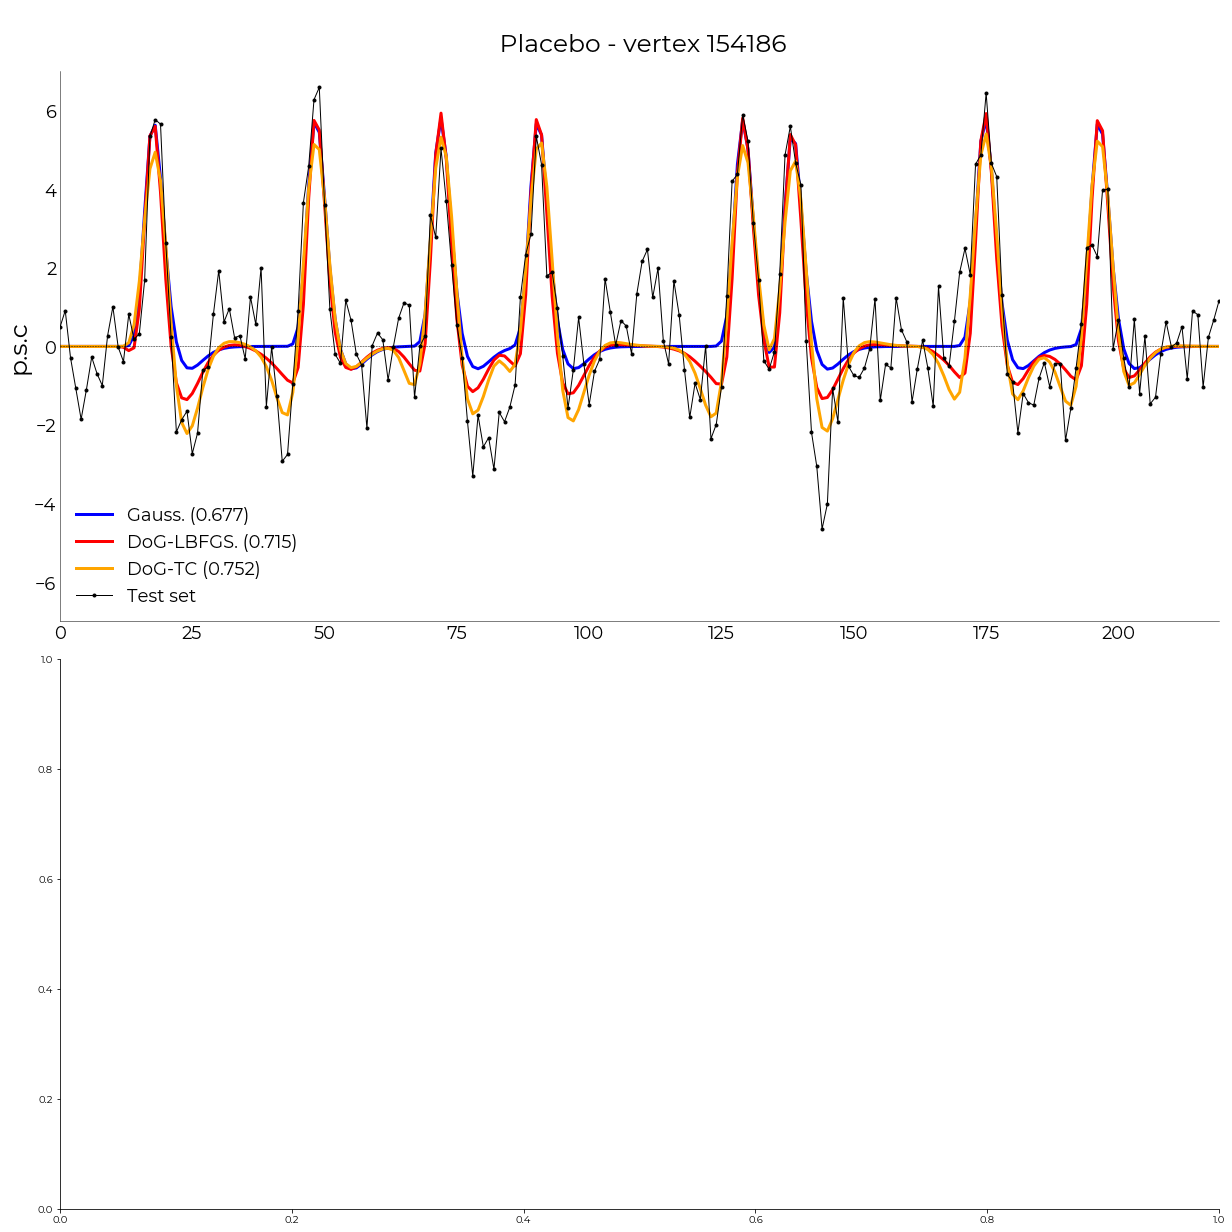

In [47]:
%matplotlib inline
#fig, axs = plt.subplots(2,2,figsize=(26,10),constrained_layout=True)
fig = plt.figure(figsize=(17,17),constrained_layout=True) #
gs = fig.add_gridspec(2,1)#, width_ratios=[5,27])
ax11 = fig.add_subplot(gs[0])
ax22 = fig.add_subplot(gs[1])


ts = [test_pred['testpred_even_V1_gauss_bgfs']/14, 
test_pred['testpred_even_V1_dog_bgfs'], 
test_pred['testpred_even_V1_dog_tc'],
test_pred['test_odd_V1_2']]


labels = [f'Gauss. ({np.round(r2_gauss, 3)})', 
            f'DoG-LBFGS. ({np.round(r2_odd.iloc[154186][3], 3)})',
            f'DoG-TC ({np.round(r2_odd.iloc[154186][2], 3)})', 
            f'Test set '
            ''
            ]

markers=[None,None,None, "."]
line_width=[3, 3, 3, 1]
color=['blue', "red", 'orange','black']

plotting.LazyPlot(
      ts,
      y_lim=[-7,7],
      color = color,
      markers = markers,
      line_width = line_width,
      axs=ax11,
      title= ' \n Placebo - vertex 154186',
      y_label="p.s.c",
      add_hline=0,
      font_size = 25,
      labels = labels,
      label_size = 18)

### Permutation tests

-0.03096840157054903
3.3333322222225924e-07


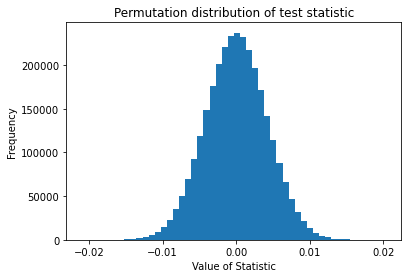

In [34]:
from scipy.stats import permutation_test

x = doglb_001['bgfs_rsq_test']
y= dogtc_001['tc_rsq_test']

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

statistic(x,y,0)
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed
res = permutation_test((x, y), statistic, vectorized=True,
                        n_resamples=100000, alternative='less')
print(res.statistic)

print(res.pvalue)

import matplotlib.pyplot as plt
plt.hist(res.null_distribution, bins=50)
plt.title("Permutation distribution of test statistic")
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.show()

#Indeed, the test statistic is negative, suggesting that the true mean of the distribution underlying x is less than that of the distribution underlying y. To determine the probability of this occuring by chance if the two samples were drawn from the same distribution, we perform a permutation test. 

#The approximate probability of obtaining a test statistic less than or equal to the observed value under the null hypothesis is 0.0225%. This is again less than our chosen threshold of 5%, so again we have significant evidence to reject the null hypothesis in favor of the alternative.

### Pycortex CVR2

In [ ]:
r2_v = pycortex.Vertex2D_fix(
    pars2.r2.values,
    data2 = pars2.ecc.values,
    subject="sub-001",
    cmap="magma",
    vmin1=0.1,
    vmax1=0.9,
    vmin2=0,
    vmax2 = 5
)

In [ ]:
import os
model = 'dog'
ctx_save = pycortex.SavePycortexViews(
    data, 
    subject='sub-001',
    fig_dir=os.path.dirname(prff),
    base_name=f"sub-001_ses-2_task-2R_rois_model-{model}_stage-iter_lbfgs",
    pivot=0,
    radius=260
    )

In [ ]:

ctx_save.save_all(
    gallery=True, 
    n_cols=4, 
    add_cms=True,
    cb=[200,900,900,1700],
    y=1.08,
    title = 'Placebo lbfgs',
    )

# do it for placebo and memantine

#### Memantine

In [5]:
sub='001'
mod_ses3 = pd.DataFrame()
ses = 'ses-3'

models = ['dogtc', 'dogbfgs', 'gauss']
rois = ['v1', 'V2', 'V3']
for mods in models:
        opt = 'LBFGS'
        mod = 'dog'
        if mods == 'dogtc':
                opt = 'TC'
        if mods == 'gauss':
                mod = 'gauss'
        
        doglb_001 = pd.DataFrame()
        for roi in rois:

                # prf_fn_s3 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"{ses}", f"sub-{sub}_{ses}_task-2R_roi-{roi}_model-{mod}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
        
                # pars_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=mod).to_df() #gettig prf parameters 
                # #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
                # data_s3 = pars_s3.loc[pars_s3.r2 != 0] 
                
                doglb_roi = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/{ses}_train-test/rsqs_{roi}_{ses}_sub-{sub}_{opt}.csv') 
                
                #gauss_roi.index = data_s2.index
                doglb_001 = pd.concat([doglb_001, doglb_roi], axis = 0)
        mod_ses3 = pd.concat([mod_ses3, doglb_001], axis = 1)

mod_ses3.to_csv(f'sub-001_{ses}_parameters_cvr2.csv')

In [6]:
mod_ses3

,Unnamed: 0,tc_rsq_train,tc_rsq_test,Unnamed: 0,bgfs_rsq_train,bgfs_rsq_test,Unnamed: 0,bgfs_rsq_train,bgfs_rsq_test
0,0,0.596040,0.497509,0,0.559108,0.420061,0,0.559108,0.420061
1,1,0.708693,0.539951,1,0.706429,0.545679,1,0.706429,0.545679
2,2,0.669816,0.594249,2,0.630690,0.526035,2,0.630690,0.526035
3,3,0.624946,0.488015,3,0.573612,0.456696,3,0.573612,0.456696
4,4,0.558727,0.383524,4,0.507149,0.345232,4,0.507149,0.345232
...,...,...,...,...,...,...,...,...,...
1194,1194,0.575486,0.498590,1194,0.518736,0.397631,1194,0.518736,0.397631
1195,1195,0.657164,0.566834,1195,0.621823,0.526227,1195,0.621823,0.526227
1196,1196,0.629512,0.514501,1196,0.582167,0.456450,1196,0.582167,0.456450
1197,1197,0.644944,0.502287,1197,0.608199,0.447129,1197,0.608199,0.447129


## Example timecourse predictions (Gauss, DoG-TC, DoG-LBFGS)

#### Plot to compare models

### Example timecourse

In [ ]:
sub, model, roi, cv, n_voxels, vox_number, session = '001', 'dog', 'V3', False, 10, 0, 'placebo'

design, prf_stim = load_dm()

param_data_tccv, _, _ = load_params_roi(sub, roi, model, cv) # data with roi of a subject for both sessions

plot_comparison(vox_number, sub, session, roi,  n_voxels, cv, design[:,:,5:], prf_stim)